The usage of noise / randomness in optimization problems is well known. Some examples includes simulated annealing,  genetic algorithms and actually my thesis. The issue of adding noise to the gradient in deep neural networks was addressed in an article called: "Adding gradient noise improves learning for very deep networks".

The addition of noise should help by reducing overfitting, avoid local minima and more easily escape flat area in the loss surface.
Having said that. Modern technics have the same properties (when talking about cnn-fc networks). SGD and its extensions is known to reduce overfitting and the incorporation of dropout and relu's also helps a lot.
The net in the exercise is very similar to one of the nets the authors tested on the article for which the noise addition did not contribute to its performances. 

# code basics

In [66]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import inspect
import pandas as pd
import numpy as np

In [250]:
# taken from https://github.com/cpury/keras_gradient_noise


def add_gradient_noise(BaseOptimizer):
    """
    Given a Keras-compatible optimizer class, returns a modified class that
    supports adding gradient noise as introduced in this paper:
    https://arxiv.org/abs/1511.06807
    The relevant parameters from equation 1 in the paper can be set via
    noise_eta and noise_gamma, set by default to 0.3 and 0.55 respectively.
    """
    if not (
        inspect.isclass(BaseOptimizer) and
        issubclass(BaseOptimizer, keras.optimizers.Optimizer)
    ):
        raise ValueError(
            'add_gradient_noise() expects a valid Keras optimizer'
        )

    class NoisyOptimizer(BaseOptimizer):
        def __init__(self, noise_eta=1, noise_gamma=0.5, **kwargs):
            super(NoisyOptimizer, self).__init__(**kwargs)
            with K.name_scope(self.__class__.__name__):
                self.noise_eta = K.variable(noise_eta, name='noise_eta')
                self.noise_gamma = K.variable(noise_gamma, name='noise_gamma')

        def get_gradients(self, loss, params):
            grads = super(NoisyOptimizer, self).get_gradients(loss, params)

            # Add decayed gaussian noise
            t = K.cast(self.iterations, K.dtype(grads[0]))
            variance = self.noise_eta / ((1 + t) ** self.noise_gamma)
            

            grads = [
                grad + K.random_normal(
                    grad.shape,
                    mean=0.0,
                    stddev=K.sqrt(variance),
                    dtype=K.dtype(grads[0])
                )
                for grad in grads
            ]

            return grads

        def get_config(self):
            config = {'noise_eta': float(K.get_value(self.noise_eta)),
                      'noise_gamma': float(K.get_value(self.noise_gamma))}
            base_config = super(NoisyOptimizer, self).get_config()
            return dict(list(base_config.items()) + list(config.items()))

    NoisyOptimizer.__name__ = 'Noisy{}'.format(BaseOptimizer.__name__)

    return NoisyOptimizer

In [265]:


def get_model(add_noise,dropout_p,input_shape,activation_func,initializer):
    '''here we get the model per spec. The basic struc is the same but 
    we can play with noise addition, dropout'''
    num_classes=10
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=activation_func,kernel_initializer=initializer,
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation=activation_func,kernel_initializer=initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_p[0]))
    model.add(Flatten())
    model.add(Dense(128, activation=activation_func,kernel_initializer=initializer))
    model.add(Dropout(dropout_p[1]))
    model.add(Dense(num_classes, activation='softmax',kernel_initializer=initializer))
    if not add_noise:
        optimizer_to_use=keras.optimizers.Adadelta()
    else:
        Noisy=add_gradient_noise(keras.optimizers.Adadelta)
        #Noisy=add_gradient_noise(keras.optimizers.Adam)
        Noisy=add_gradient_noise(keras.optimizers.SGD)

        optimizer_to_use=Noisy()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer_to_use,
                  metrics=['accuracy'])

    
    return model

def train_and_test(model,total_iteration,x_test,y_test,x_train,y_train,epoces_per_step,add_noise):
    '''a simple func doing the train in loops so we can take a look of train and test results as we
    train the net more and more. The final result is a dataframe with the run data'''
    result_list=[]
    for iteration in range(total_iteration):
        temp_dict={}

        model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epoces_per_step,
                      verbose=1,
                      validation_data=(x_test, y_test))
        score_train = model.evaluate(x_train, y_train, verbose=0)
        score_test = model.evaluate(x_test, y_test, verbose=0)
        temp_dict["epochs"]=(iteration+1)*epoces_per_step
        temp_dict["add_noise"]=add_noise
        temp_dict["train_loss"]=score_train[0]
        temp_dict["train_accuracy"]=score_train[1]
        temp_dict["test_loss"]=score_test[0]
        temp_dict["test_accuracy"]=score_test[1]
        result_list.append(temp_dict)
        print("iteration {} out of {}".format(iteration+1,total_iteration))
    results_df=pd.DataFrame(result_list)
    column_order_list=["epochs","add_noise","train_accuracy","test_accuracy","train_loss","test_loss"]
    results_df=results_df[column_order_list]
    return results_df
    

In [252]:
def get_train_test(train_num="all"):
    '''taking care of importing and some (very limited) preproccessing'''
    
    img_rows=28
    img_cols =28
    num_classes=10

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    if train_num!="all":
        x_train=x_train[:train_num]
        y_train=y_train[:train_num]
        
    

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    a=np.unique(y_train, return_counts=True)
    df=pd.DataFrame([])
    df["lable"]=a[0]
    df["count"]=a[1]
    df.plot("lable","count",kind="bar",title="train counts",color="r",legend=False)
    a=np.unique(y_test, return_counts=True)
    df=pd.DataFrame([])
    df["lable"]=a[0]
    df["count"]=a[1]
    df.plot("lable","count",kind="bar",title="test counts",color="b",legend=False)

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, x_test, y_train,y_test,input_shape

## Actual work

## Lets train two networks. The original provided and a second where we add the noise to the gradient. We will use the entire dataset

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


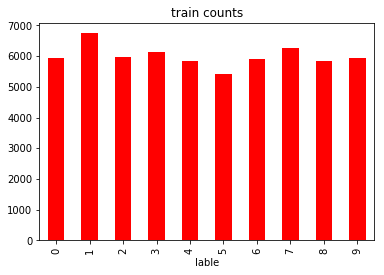

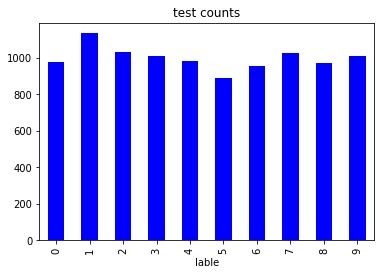

In [253]:
train_num="all"
x_train, x_test, y_train,y_test,input_shape=get_train_test(train_num)

# run settings

In [254]:
#add_noise=False
dropout_p=[0.25,0.5] 
activation_func="relu"
initializer='glorot_uniform'#glorot_uniform is default. also try zeros
batch_size=128
epoces_per_step=3


# model generation

In [260]:

add_noise=False
model_clean=get_model(add_noise,dropout_p,input_shape,activation_func,initializer)
add_noise=True
model_noise=get_model(add_noise,dropout_p,input_shape,activation_func,initializer)

# train and test

In [261]:
total_iteration=5
results_clean_df=train_and_test(model_clean,total_iteration,x_test,y_test,x_train,y_train,epoces_per_step,add_noise)
total_iteration=7
results_noise_df=train_and_test(model_noise,total_iteration,x_test,y_test,x_train,y_train,epoces_per_step,add_noise)


Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 119s 2ms/step - loss: 0.3243 - acc: 0.9000 - val_loss: 0.0784 - val_acc: 0.9752
Epoch 2/3
60000/60000 [==============================] - 114s 2ms/step - loss: 0.1120 - acc: 0.9669 - val_loss: 0.0572 - val_acc: 0.9825
Epoch 3/3
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0862 - acc: 0.9739 - val_loss: 0.0448 - val_acc: 0.9852
iteration 1 out of 5
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0715 - acc: 0.9785 - val_loss: 0.0381 - val_acc: 0.9876
Epoch 2/3
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0637 - acc: 0.9809 - val_loss: 0.0339 - val_acc: 0.9884
Epoch 3/3
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0574 - acc: 0.9833 - val_loss: 0.0310 - val_acc: 0.9889
iteration 2 out of 5
Train on 60000 samples, validate on 

In [262]:
#results of original net
results_clean_df

,epochs,add_noise,train_accuracy,test_accuracy,train_loss,test_loss
0,3,True,0.987450,0.9852,0.042484,0.044803
1,6,True,0.992283,0.9889,0.025985,0.031016
2,9,True,0.993917,0.9901,0.019765,0.028393
3,12,True,0.995417,0.9911,0.015845,0.026647
4,15,True,0.996133,0.9915,0.013438,0.026062


In [263]:
#results of noisy net
results_noise_df

,epochs,add_noise,train_accuracy,test_accuracy,train_loss,test_loss
0,3,True,0.865700,0.8739,0.489644,0.467638
1,6,True,0.906517,0.9126,0.324232,0.307185
2,9,True,0.922650,0.9252,0.273698,0.261085
3,12,True,0.929417,0.9315,0.243103,0.230492
4,15,True,0.935233,0.9390,0.223427,0.213230
5,18,True,0.940233,0.9421,0.204773,0.197581
6,21,True,0.943950,0.9459,0.194029,0.185670


we can see thet noisy net learns slower and not as good as original net

now lets move from Adadelta to sgd when applying the noise. sgd does not carry with it history of gradient so should work better (this is also what they used in the article). To save time we will directly demonstrate on a vary bad initiation. All weights are set to zero so no training in regular methods


In [269]:
dropout_p=[0,0]
activation_func="relu"
initializer='zeros'#glorot_uniform is default. also try zeros
batch_size=128
epoces_per_step=3

In [270]:
add_noise=True
model_noise_sgd=get_model(add_noise,dropout_p,input_shape,activation_func,initializer)

In [271]:
total_iteration=3
results_noise_df_sgd_zeros=train_and_test(model_noise_sgd\
                                          ,total_iteration,x_test,y_test,x_train,y_train,epoces_per_step,add_noise)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 106s 2ms/step - loss: 1.6821 - acc: 0.4327 - val_loss: 0.4231 - val_acc: 0.8795
Epoch 2/3
60000/60000 [==============================] - 104s 2ms/step - loss: 0.3648 - acc: 0.8896 - val_loss: 0.2932 - val_acc: 0.9165
Epoch 3/3
60000/60000 [==============================] - 103s 2ms/step - loss: 0.2820 - acc: 0.9162 - val_loss: 0.2448 - val_acc: 0.9262
iteration 1 out of 3
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 103s 2ms/step - loss: 0.2441 - acc: 0.9284 - val_loss: 0.2248 - val_acc: 0.9288
Epoch 2/3
60000/60000 [==============================] - 104s 2ms/step - loss: 0.2204 - acc: 0.9345 - val_loss: 0.1905 - val_acc: 0.9425
Epoch 3/3
60000/60000 [==============================] - 104s 2ms/step - loss: 0.2018 - acc: 0.9400 - val_loss: 0.1872 - val_acc: 0.9429
iteration 2 out of 3
Train on 60000 samples, validate on 

In [272]:
results_noise_df_sgd_zeros

,epochs,add_noise,train_accuracy,test_accuracy,train_loss,test_loss
0,3,True,0.924033,0.9262,0.252632,0.244843
1,6,True,0.942017,0.9429,0.191667,0.187181
2,9,True,0.949850,0.9488,0.163322,0.172472


we can see that in spite the poor initialization, the net is capable to learn, much faster then perviously when used Adadelta. 

## lets take a much smaller dataset, induce overfit and compare the two methods

x_train shape: (500, 28, 28, 1)
500 train samples
10000 test samples


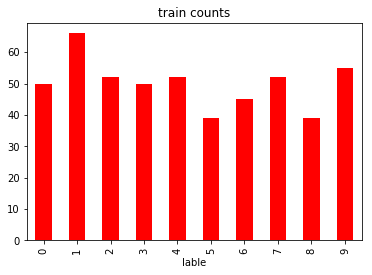

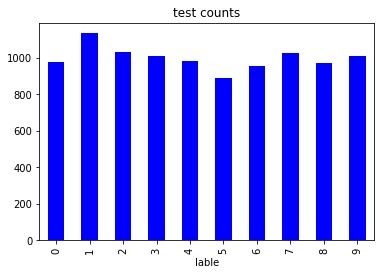

In [273]:
train_num=500
x_train, x_test, y_train,y_test,input_shape=get_train_test(train_num)

# original net:

In [288]:
dropout_p=[0.25,0.5]
activation_func="relu"
initializer='glorot_uniform'#glorot_uniform is default. also try zeros
batch_size=128
epoces_per_step=5

In [289]:
add_noise=False
model_small_dataset=get_model(add_noise,dropout_p,input_shape,activation_func,initializer)

In [290]:
total_iteration=5
results_small_dataset=train_and_test(model_small_dataset\
                                          ,total_iteration,x_test,y_test,x_train,y_train,epoces_per_step,add_noise)

Train on 500 samples, validate on 10000 samples
Epoch 1/5
500/500 [==============================] - 9s 17ms/step - loss: 2.2537 - acc: 0.2100 - val_loss: 2.1082 - val_acc: 0.4194
Epoch 2/5
500/500 [==============================] - 6s 13ms/step - loss: 1.9629 - acc: 0.4620 - val_loss: 1.7315 - val_acc: 0.5189
Epoch 3/5
500/500 [==============================] - 6s 13ms/step - loss: 1.5045 - acc: 0.5760 - val_loss: 1.3496 - val_acc: 0.6059
Epoch 4/5
500/500 [==============================] - 6s 13ms/step - loss: 1.2722 - acc: 0.6320 - val_loss: 1.0532 - val_acc: 0.7118
Epoch 5/5
500/500 [==============================] - 7s 13ms/step - loss: 0.9070 - acc: 0.7220 - val_loss: 1.0189 - val_acc: 0.6919
iteration 1 out of 5
Train on 500 samples, validate on 10000 samples
Epoch 1/5
500/500 [==============================] - 7s 13ms/step - loss: 0.8096 - acc: 0.7820 - val_loss: 0.8656 - val_acc: 0.7328
Epoch 2/5
500/500 [==============================] - 6s 13ms/step - loss: 0.5639 - acc: 0.8

In [291]:
results_small_dataset

,epochs,add_noise,train_accuracy,test_accuracy,train_loss,test_loss
0,5,False,0.810,0.6919,0.674624,1.018910
1,10,False,0.926,0.8450,0.255042,0.513588
2,15,False,0.938,0.8379,0.156744,0.499964
3,20,False,0.986,0.8627,0.084461,0.457826
4,25,False,0.994,0.8794,0.048178,0.416570


# sgd with noise, no dropout

In [284]:
dropout_p=[0,0]
activation_func="relu"
initializer='glorot_uniform'#glorot_uniform is default. also try zeros
batch_size=128
epoces_per_step=15

In [285]:
add_noise=True
model_noise_sgd_small_dataset=get_model(add_noise,dropout_p,input_shape,activation_func,initializer)

In [286]:
total_iteration=8
results_noise_df_sgd_small_dataset=train_and_test(model_noise_sgd_small_dataset\
                                          ,total_iteration,x_test,y_test,x_train,y_train,epoces_per_step,add_noise)

Train on 500 samples, validate on 10000 samples
Epoch 1/15
500/500 [==============================] - 8s 17ms/step - loss: 2.3141 - acc: 0.0440 - val_loss: 2.2977 - val_acc: 0.0773
Epoch 2/15
500/500 [==============================] - 7s 13ms/step - loss: 2.2856 - acc: 0.1400 - val_loss: 2.2935 - val_acc: 0.1044
Epoch 3/15
500/500 [==============================] - 7s 13ms/step - loss: 2.2694 - acc: 0.1300 - val_loss: 2.2650 - val_acc: 0.1170
Epoch 4/15
500/500 [==============================] - 6s 13ms/step - loss: 2.2462 - acc: 0.1620 - val_loss: 2.2463 - val_acc: 0.1997
Epoch 5/15
500/500 [==============================] - 7s 13ms/step - loss: 2.2191 - acc: 0.2620 - val_loss: 2.2169 - val_acc: 0.2870
Epoch 6/15
500/500 [==============================] - 7s 13ms/step - loss: 2.1844 - acc: 0.2760 - val_loss: 2.1845 - val_acc: 0.2221
Epoch 7/15
500/500 [==============================] - 7s 13ms/step - loss: 2.1343 - acc: 0.3020 - val_loss: 2.1198 - val_acc: 0.3220
Epoch 8/15
500/500 [=

500/500 [==============================] - 6s 13ms/step - loss: 0.0729 - acc: 0.9860 - val_loss: 0.5697 - val_acc: 0.8459
Epoch 15/15
500/500 [==============================] - 6s 13ms/step - loss: 0.0699 - acc: 0.9840 - val_loss: 0.5861 - val_acc: 0.8405
iteration 8 out of 8


In [287]:
results_noise_df_sgd_small_dataset

,epochs,add_noise,train_accuracy,test_accuracy,train_loss,test_loss
0,15,True,0.684,0.5886,1.329578,1.485861
1,30,True,0.890,0.7900,0.447785,0.676784
2,45,True,0.918,0.8109,0.285252,0.578741
3,60,True,0.938,0.8242,0.217201,0.558299
4,75,True,0.958,0.8401,0.160263,0.539524
5,90,True,0.946,0.8084,0.161015,0.644017
6,105,True,0.968,0.8394,0.095672,0.580410
7,120,True,0.988,0.8405,0.068617,0.586083


 we can see that in this case modern methods works faster and better

# conclusion:
The proposed method seems to work however it perform better job then std modern methods. This is the same result obtained by the relevant article